In [1]:
import os
import time

import dill
import matplotlib.pyplot as plt
import pyro
import seaborn as sns
import torch
from chirho.dynamical.handlers import LogTrajectory
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import simulate
from pyro.infer import Predictive

pyro.settings.set(module_local_params=True)

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)


import matplotlib.pyplot as plt
import seaborn as sns
import torch

from collab.foraging import locust as lc
from collab.foraging import toolkit as ft
from collab.utils import find_repo_root, progress_saver

smoke_test = "CI" in os.environ
subset_starts = 1  # 420
subset_ends = 30 if smoke_test else 900
desired_frames = 50 if smoke_test else 250
num_iterations = 50 if smoke_test else 100
num_samples = 20 if smoke_test else 500
num_steps = 10 if smoke_test else 1000
sample_size = 100 if smoke_test else 300
locust_sample_size = 100 if smoke_test else 178770
root = find_repo_root()


notebook_starts = time.time()

In [2]:
locust_count_data_path = os.path.join(
    root, "data/foraging/locust/ds/locust_counts15EQ20191202.pkl"
)

with open(locust_count_data_path, "rb") as f:
    locust_count_data = dill.load(f)

count_data = locust_count_data["count_data"]
init_state = locust_count_data["init_state"]

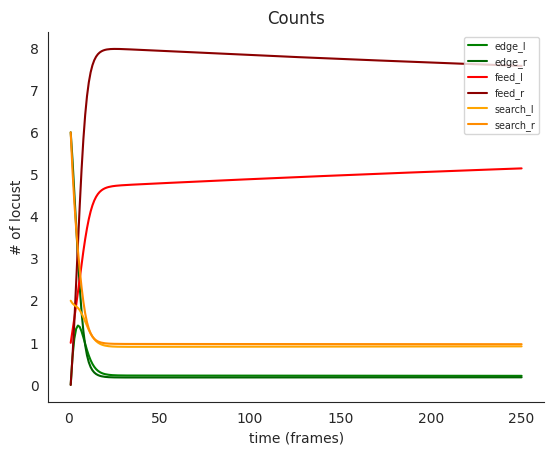

In [4]:
start_time = torch.tensor(1).float()
end_time = torch.tensor(250 + 1).float()
step_size = 1
logging_times = torch.arange(start_time, end_time, step_size)

true_wander = torch.tensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
true_attraction = torch.tensor([0.01, 0.01, 0.02, 0.02, 0.06, 0.1, 0.01, 0.01, 0.01])


locust_true = lc.LocustDynamics(true_attraction, true_wander)

with TorchDiffEq(method="rk4", options=dict(step_size=.5)), LogTrajectory(
    logging_times
) as lt:
    simulate(locust_true, init_state, start_time, end_time)

locust_true_traj = lt.trajectory

ft.plot_ds_trajectories(locust_true_traj, logging_times, window_size=0)

In [5]:
keys = ["edge_l", "edge_r", "search_l", "search_r", "feed_l", "feed_r"]

with pyro.poutine.trace() as tr:
    lc.locust_noisy_model(locust_true_traj)

synthetic_stacked = tr.trace.nodes["counts_obs"]["value"]
assert torch.all(torch.eq(torch.sum(synthetic_stacked, dim=1), 15))


synthetic_data = {
    f"{key}_obs": tensor
    for key, tensor in zip(keys, tr.trace.nodes["counts_obs"]["value"].unbind(dim=1))
}
assert count_data.keys() == synthetic_data.keys()

assert synthetic_stacked[0, 0] == synthetic_data["edge_l_obs"][0]
assert torch.equal(synthetic_stacked[:3, 3], synthetic_data["search_r_obs"][:3])

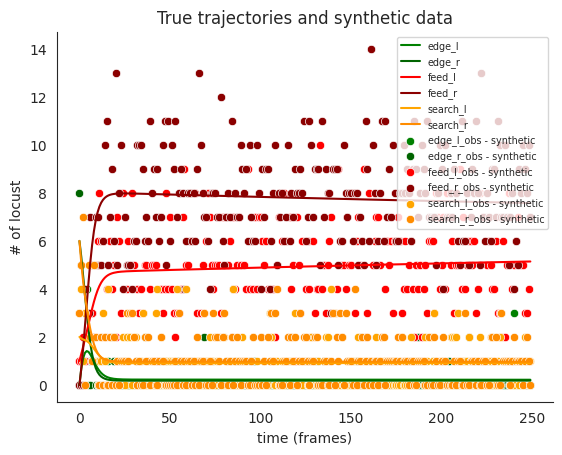

In [6]:
ft.plot_ds_trajectories(
    locust_true_traj,
    window_size=0,
    title="True trajectories and synthetic data",
    scatter_data=synthetic_data,
    scatter_data_type="synthetic",
)

In [7]:
def get_locust_prior_samples_synthetic():
    prior_predictive = Predictive(lc.simulated_bayesian_locust, num_samples=num_samples)
    locust_prior_samples = prior_predictive(init_state, start_time, logging_times)
    return locust_prior_samples


locust_prior_samples = progress_saver(
    name="locust_prior_samples_synthetic",
    subfolder="foraging/locust/ds",
    properties=[num_samples],
    property_names=["num_samples"],
    code_f=get_locust_prior_samples_synthetic,
)

/home/rafal/s78projects/collaborative-intelligence/data/foraging/locust/ds/locust_prior_samples_synthetic_num_samples_300.pkl
path found, loading data


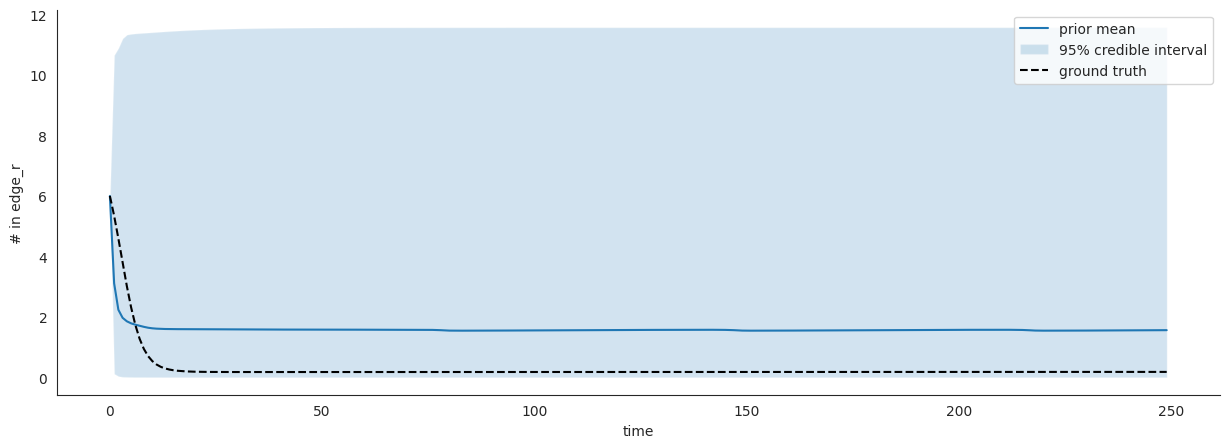

In [8]:
state = "edge_r"
color = "green"


fig, ax = plt.subplots(1, 1, figsize=(15, 5))


ft.ds_uncertainty_plot(
    state_pred=locust_prior_samples[state],
    data=locust_true_traj[state],
    ylabel=f"# in {state}",
    color=color,
    data_label="ground truth",
    ax=ax,
    legend=True,
    test_plot=False,
    mean_label="prior mean",
)


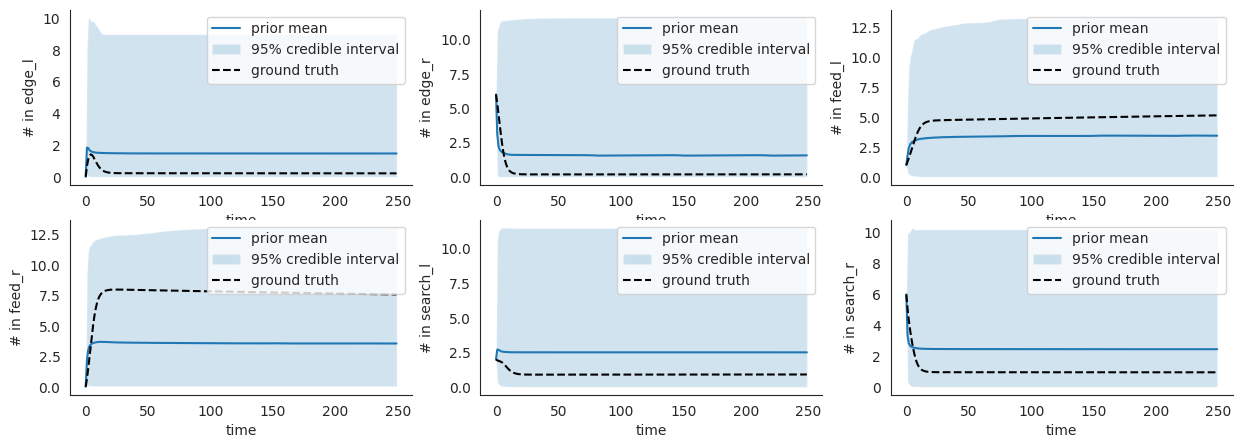

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5))

ax = ax.flatten()

for i, state, color in zip(
    range(6),
    ["edge_l", "edge_r", "feed_l", "feed_r", "search_l", "search_r"],
    ["green", "darkgreen", "red", "darkred", "orange", "darkorange"],
):
    ft.ds_uncertainty_plot(
        state_pred=locust_prior_samples[state],
        data=locust_true_traj[state],
        ylabel=f"# in {state}",
        color=color,
        data_label="ground truth",
        ax=ax[i],
        legend=True,
        test_plot=False,
        mean_label="prior mean",
    )

In [11]:


def get_locust_posterior_samples_synthetic():

    guide_synthetic = ft.run_svi_inference(
        model=lc.conditioned_locust_model,
        num_steps=num_steps,
        verbose=True,
        lr=0.03,
        blocked_sites=["counts_obs"],
        obs_times=logging_times,
        data=synthetic_data,
        init_state=init_state,
        start_time=start_time,
    )
    
    locust_predictive = Predictive(
        lc.simulated_bayesian_locust, guide=guide_synthetic, num_samples=num_samples
    )
    locust_posterior_samples_synthetic = locust_predictive(
        init_state, start_time, logging_times
    )
    return locust_posterior_samples_synthetic


locust_posterior_samples_synthetic = progress_saver(
    name="locust_posterior_samples_synthetic",
    subfolder="foraging/locust/ds",
    properties=[num_samples],
    property_names=["num_samples"],
    code_f=get_locust_posterior_samples_synthetic,
)

/home/rafal/s78projects/collaborative-intelligence/data/foraging/locust/ds/locust_posterior_samples_synthetic_num_samples_300.pkl
path found, loading data


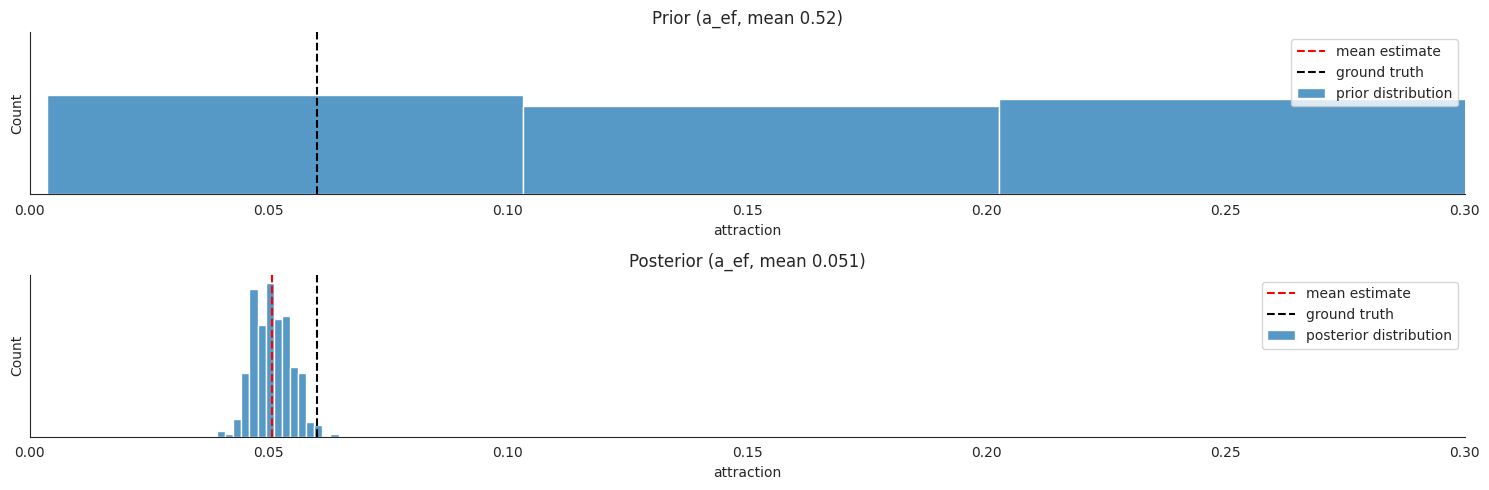

In [12]:
lc.plot_ds_estimates(
    locust_prior_samples,
    locust_posterior_samples_synthetic,
    "attraction",
    4,
    ground_truth=True,
    true_attraction=true_attraction,
    true_wander=true_wander,
    xlim=.3,
)

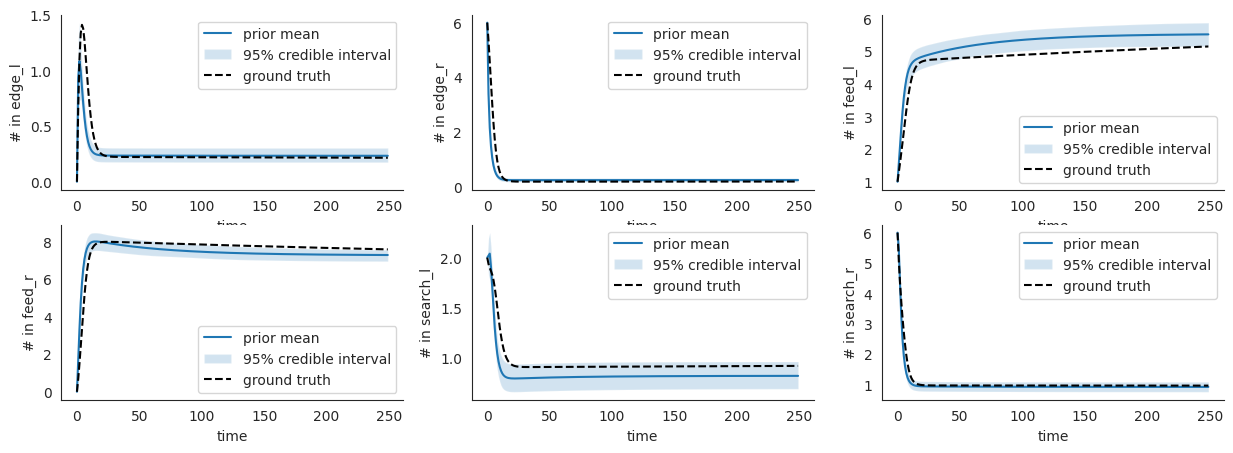

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5))
ax = ax.flatten()

for i, state, color in zip(
    range(6),
    ["edge_l", "edge_r", "feed_l", "feed_r", "search_l", "search_r"],
    ["green", "darkgreen", "red", "darkred", "orange", "darkorange"],
):
    ft.ds_uncertainty_plot(
        state_pred=locust_posterior_samples_synthetic[state],
        data=locust_true_traj[state],
        ylabel=f"# in {state}",
        color=color,
        data_label="ground truth",
        ax=ax[i],
        legend=True,
        test_plot=False,
        mean_label="prior mean",
    )

In [16]:
print(num_samples)

def get_locust_posterior_samples_real():

    guide_real = ft.run_svi_inference(
        model=lc.conditioned_locust_model,
        num_steps=num_steps,
        verbose=True,
        lr=0.03,
        blocked_sites=["counts_obs"],
        obs_times=logging_times,
        data=count_data,
        init_state=init_state,
        start_time=start_time,
    )


    locust_predictive = Predictive(
        lc.simulated_bayesian_locust, guide=guide_real, num_samples=num_samples
    )
    locust_posterior_samples_real = locust_predictive(
        init_state, start_time, logging_times
    )
    return locust_posterior_samples_real


locust_posterior_samples_real = progress_saver(
    name="locust_posterior_samples_real",
    subfolder="foraging/locust/ds",
    properties=[num_samples],
    property_names=["num_samples"],
    code_f=get_locust_posterior_samples_real,
)


300
/home/rafal/s78projects/collaborative-intelligence/data/foraging/locust/ds/locust_posterior_samples_real_num_samples_300.pkl
path found, loading data


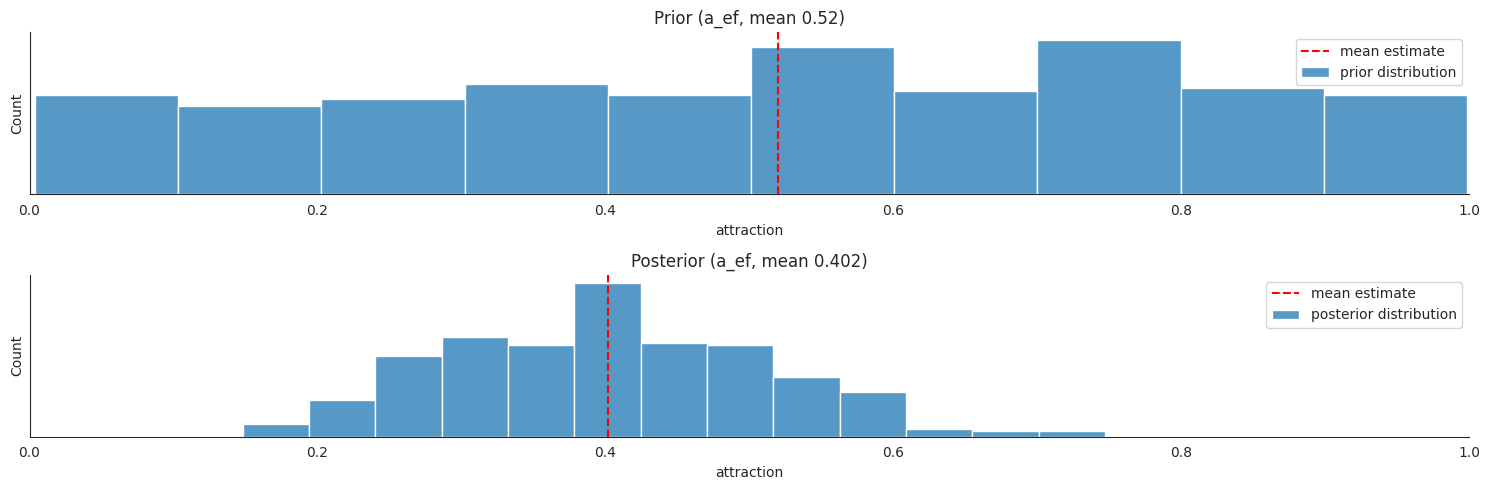

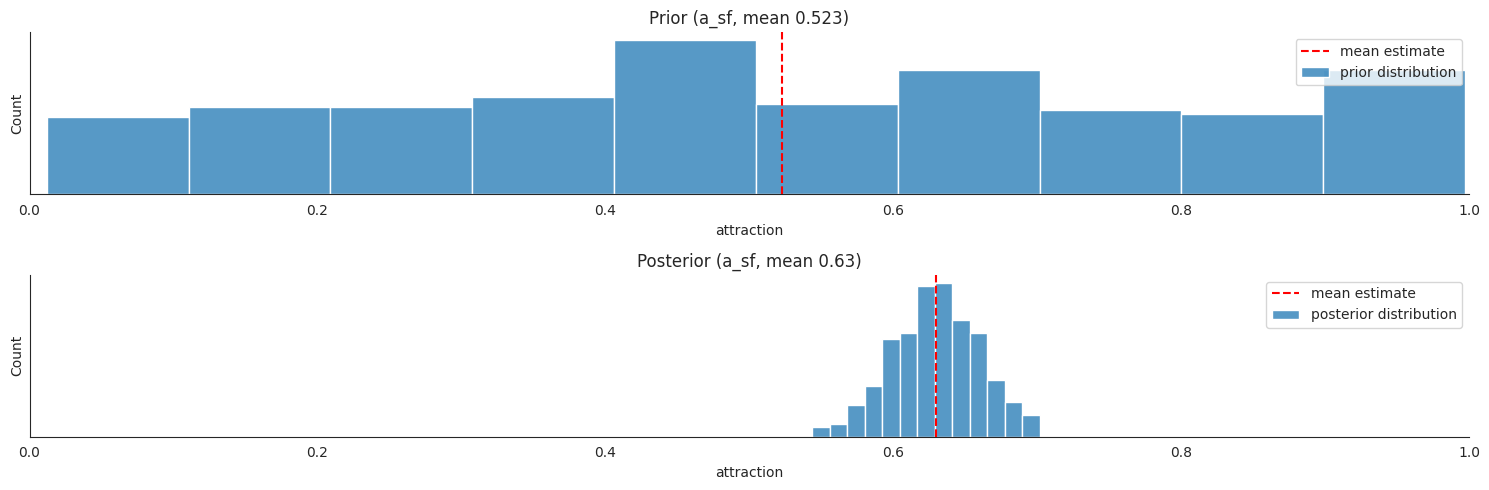

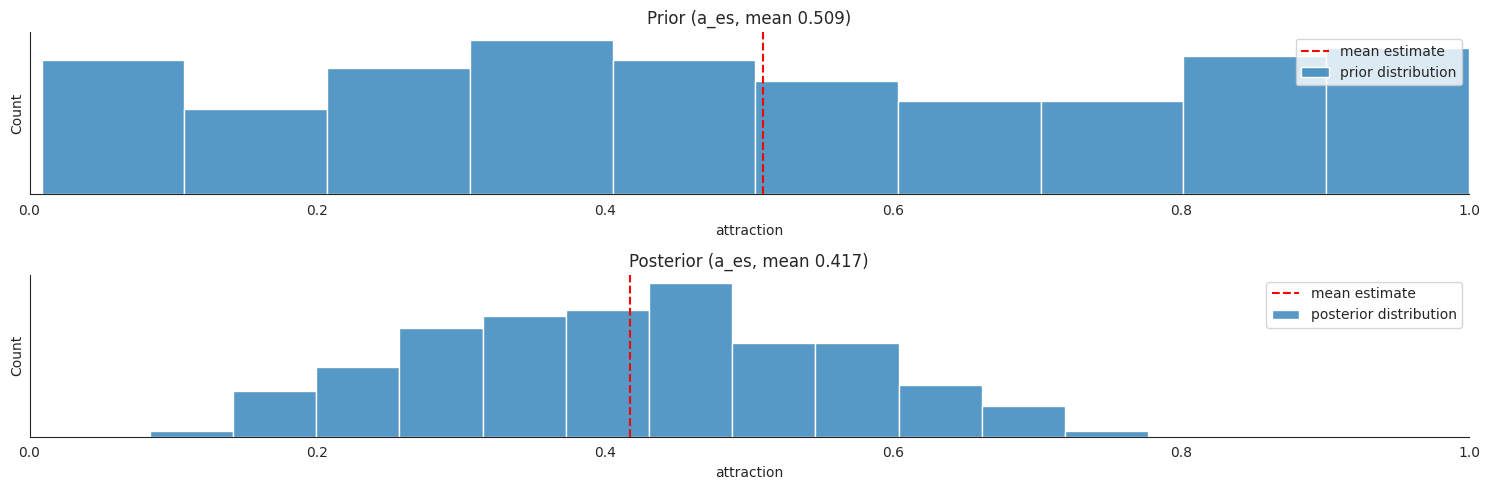

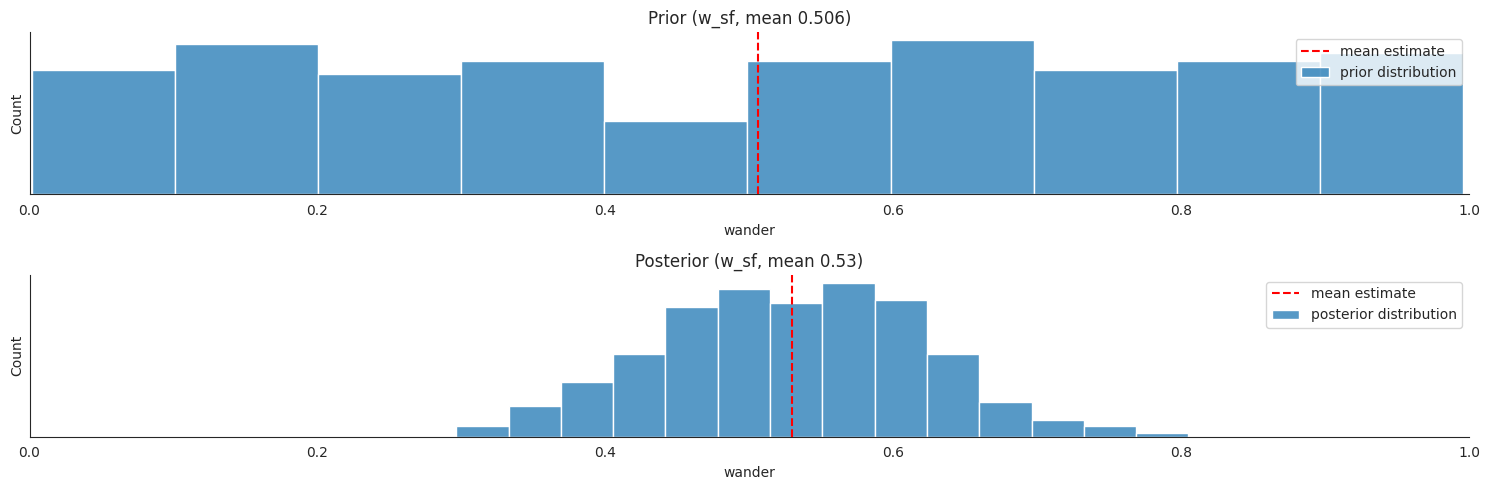

In [17]:
lc.plot_ds_estimates(
    locust_prior_samples,
    locust_posterior_samples_real,
    "attraction",
    4,
    ground_truth=False,
    xlim=1,
)

lc.plot_ds_estimates(
    locust_prior_samples,
    locust_posterior_samples_real,
    "attraction",
    5,
    ground_truth=False,
    xlim=1,
)


lc.plot_ds_estimates(
    locust_prior_samples,
    locust_posterior_samples_real,
    "attraction",
    2,
    ground_truth=False,
    xlim=1,
)


lc.plot_ds_estimates(
    locust_prior_samples,
    locust_posterior_samples_real,
    "wander",
    3,
    ground_truth=False,
    xlim=1,
)

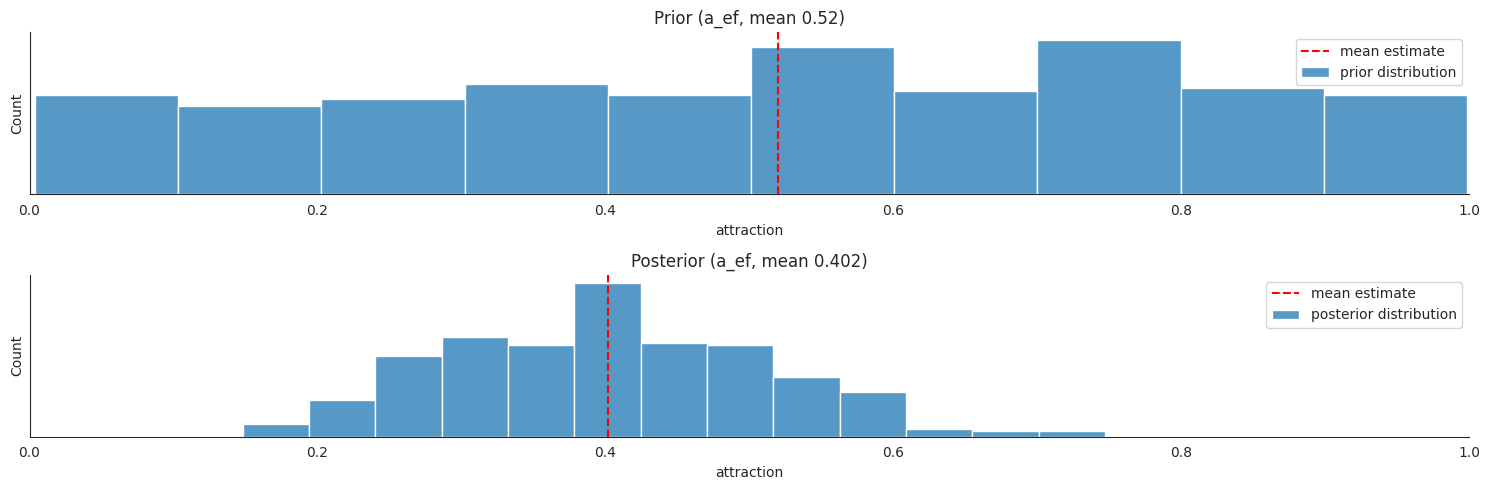

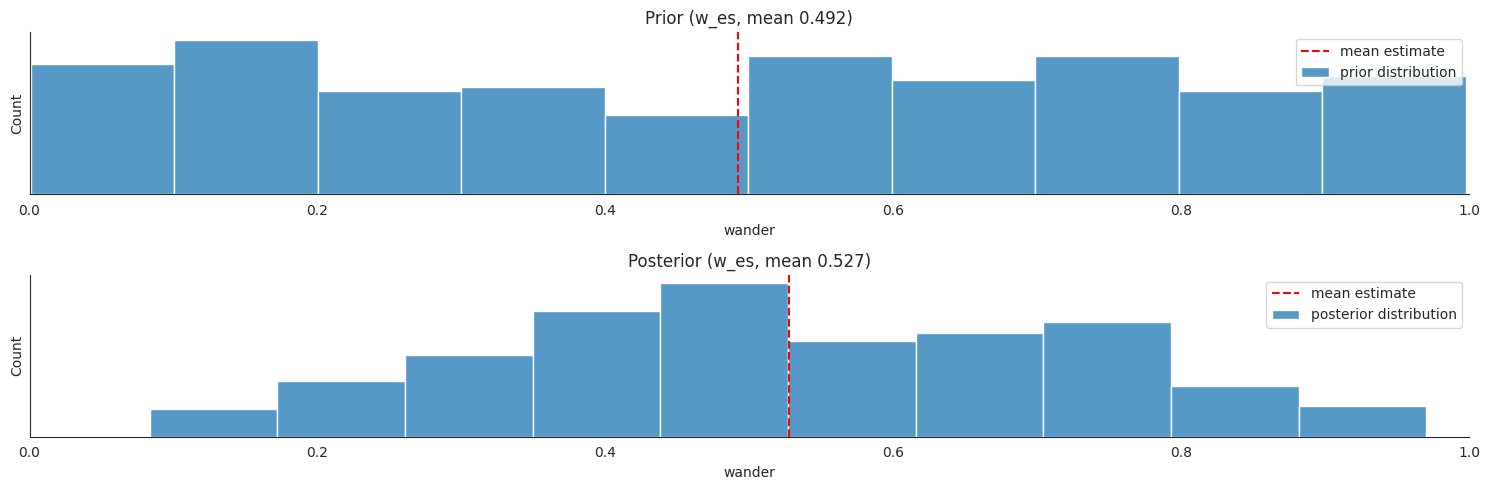

In [18]:
lc.plot_ds_estimates(
    locust_prior_samples,
    locust_posterior_samples_real,
    "attraction",
    4,
    ground_truth=False,
    xlim=1,
)


lc.plot_ds_estimates(
    locust_prior_samples,
    locust_posterior_samples_real,
    "wander",
    1,
    ground_truth=False,
    xlim=1,
)

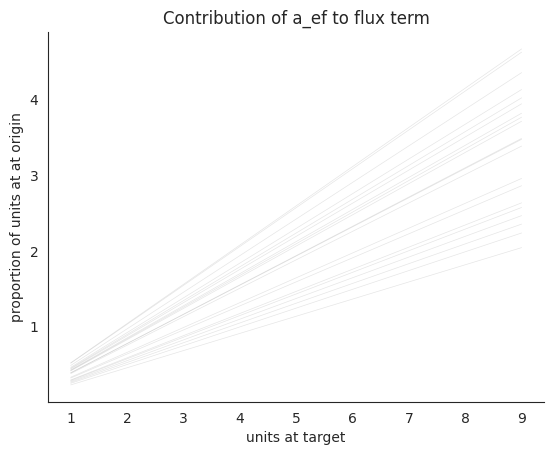

In [19]:
lc.plot_ds_interaction(
    locust_posterior_samples_real, "attraction", 4, xlim=10, num_lines=20
)

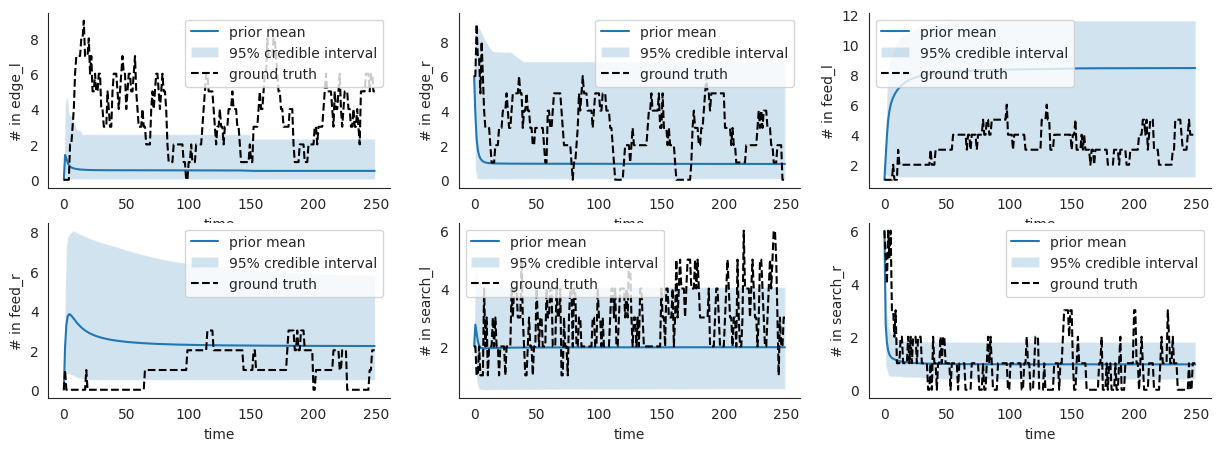

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5))
ax = ax.flatten()

for i, state, color in zip(
    range(6),
    ["edge_l", "edge_r", "feed_l", "feed_r", "search_l", "search_r"],
    ["green", "darkgreen", "red", "darkred", "orange", "darkorange"],
):
    ft.ds_uncertainty_plot(
        state_pred=locust_posterior_samples_real[state],
        data=count_data[f"{state}_obs"],
        ylabel=f"# in {state}",
        color=color,
        data_label="ground truth",
        ax=ax[i],
        legend=True,
        test_plot=False,
        mean_label="prior mean",
    )

In [29]:
notebook_ends = time.time()
print(
    "notebook took",
    notebook_ends - notebook_starts,
    "seconds, that is ",
    (notebook_ends - notebook_starts) / 60,
    "minutes to run",
)

notebook took 6313.446610689163 seconds, that is  105.22411017815271 minutes to run
